<a href="https://colab.research.google.com/github/MercyNgila/Mobile-Phone-Sentiment-Analysis/blob/main/Mobile_Phone_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Business Understanding

## 1.1. Problem Statement

Purchasing a product is an interaction between two entities, consumers and business owners. Consumers often use reviews to make decisions about what products to buy, while businesses, on the other hand, not only want to sell their products but also want to receive feedback in terms of consumer reviews. Consumer reviews about purchased products shared on the internet have a great impact. Human nature is generally structured to make decisions based on analyzing and getting the benefit of other consumer experience and opinions because others often have a great influence on our beliefs, behaviors, perception of reality, and the choices we make. Hence, we ask others for their feedback whenever we are deciding on doing something. Additionally, this fact applies not only to consumers but also to organizations and institutions.

As social media networks have evolved, so have the ways that consumers express their opinions and feelings. With the vast amount of data now available online, it has become a challenge to extract useful information from it all. Sentiment analysis has emerged as a way to predict the polarity (positive, negative, or neutral) of consumer opinion, which can help consumers better understand the textual data.

E-commerce websites have increased in popularity to the point where consumers rely on them for buying and selling. These websites give consumers the ability to write comments about different products and services, which has resulted in a huge amount of reviews becoming available. Consequently, the need to analyze these reviews to understand consumers’ feedback has increased for both vendors and consumers. However, it is difficult to read all the feedback for a particular item, especially for popular items with many comments. 

In this research, we attempt to build a predictor for consumers’ satisfaction on mobile phone products based on the reviews. We will also attempt to understand the factors that contribute to classifying reviews as positive, negative or neutral (based on important or most frequent words). This is believed to help companies improve their products and also help potential buyers make better decisions when buying products.


### 1.1.1. Main objective

- To perform a sentiment analysis of mobile phone reviews from Amazon website to determine how these reviews help consumers to have conﬁdence that they have made the right decision about their purchases.

### 1.1.2. Specific Objectives

- To help companies understand their consumers’ feedback to maintain their products/services or enhance them.
- To provide insights to companies in curating offers on speciﬁc products to increase their proﬁts and customer satisfaction.
- To understand the factors that contribute to classifying reviews as positive, negative or neutral (based on important or most frequent words).
- To determine mobile phones key features that influence smartphone purchases.
- To perform a market segmentation of consumers based on their reviews
- To advise the advertisement department in companies on these key features to use as selling points and to specific customer segments  in upcoming advertisements.

### 1.1.3. Metrics of Success

The best performing model will be selected based on:
- An accuracy score > 80%
- An F1 score > 0.85 


# 2. Data Understanding

The data used for this project is obtained from [data.world](https://data.world/promptcloud/amazon-mobile-phone-reviews) and contains more than 400 thousand reviews  of unlocked mobile phones sold on [amazon.com](https://www.amazon.com/). The data was collected from 2016 and last updated in April 2022. The data contains 6 columns:
- Product_name : Contains the name of the product
- Brand : Contains the brand of the product
- Price : Contains the price of the brans
- Rating : Contains the rating awarded to that product
- Reviews : Contains the review of that product
- Review_votes : Number of people who found the review helpful



# 3. Loading Relevant Libraries & Data

## 3.1. Loading Libraries

In [739]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

In [740]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 3.2. Loading Data

In [741]:
# loading the data

df = pd.read_csv('/content/drive/Shareddrives/Alpha/Data/Amazon Combined Data.csv')
df.head()

,Rating,Review Title,Review,Location and Date of Review,Affiliated Company,Brand and Features,Price
0,4.0 out of 5 stars,"\n.. not what ordered, not New... but it works...","\nSo first off...it's not what I ordered, but ...","Reviewed in the United States on February 11, ...",Visit the RCA Store,"RCA Reno Smartphone, 4G LTE, 16GB, And...",$69.99
1,3.0 out of 5 stars,\nNot for Cricket Wireless and this two review...,"\nThe phone itself is a okay android device, b...","Reviewed in the United States on February 4, 2021",Visit the RCA Store,"RCA Reno Smartphone, 4G LTE, 16GB, And...",$69.99
2,3.0 out of 5 stars,\nWill not work on T-Mobile sysem!\n,\nNew phone write up indicates T-Mobile system...,"Reviewed in the United States on June 7, 2022",Visit the RCA Store,"RCA Reno Smartphone, 4G LTE, 16GB, And...",$69.99
3,3.0 out of 5 stars,\nA burner or for a kid\n,\nI use this as a burner w/o a sim card in it....,"Reviewed in the United States on April 14, 2022",Visit the RCA Store,"RCA Reno Smartphone, 4G LTE, 16GB, And...",$69.99
4,4.0 out of 5 stars,\nIt works okay\n,\nIt works fine\n,"Reviewed in the United States on August 13, 2022",Visit the RCA Store,"RCA Reno Smartphone, 4G LTE, 16GB, And...",$69.99


## 3.3. Previewing Data

In [742]:
# checking the shape of the data

print(f'The data has {df.shape[0]} rows and {df.shape[1]} columns')

The data has 17198 rows and 7 columns


In [743]:
# checking the data types of the data

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17198 entries, 0 to 17197
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Rating                       17198 non-null  object
 1   Review Title                 17198 non-null  object
 2   Review                       17168 non-null  object
 3   Location and Date of Review  17198 non-null  object
 4   Affiliated Company           17198 non-null  object
 5   Brand and Features           17198 non-null  object
 6   Price                        17198 non-null  object
dtypes: object(7)
memory usage: 940.6+ KB


# 4. Data Cleaning

## 4.1. Missing values
- Checking for missing values


In [744]:
# Define a function to get missing data
def missing_data(data):
    missing_data = data.isna().sum()
    missing_data = missing_data[missing_data>0]
    return missing_data

In [745]:
# Getting the sum of missing values per column

missing_data(df).to_frame()

,0
Review,30


Out of the 7 columns, only the review's column has missing values.

Since the dataset is large, the missing values can be dropped and still retain relevant information.

In [746]:
# Dropping the missing values

df.dropna(inplace = True)

# Confirming there are no missing values 

missing_data(df).to_frame()

,0


## 4.2. Duplicates

In [747]:
# Checking for duplicates

print(f"The data has {df.duplicated().sum()} duplicated rows")

The data has 6595 duplicated rows


In [748]:
# Exploring the duplicates

duplicates = df[df.duplicated(keep = 'first')]

duplicates.head(4)

,Rating,Review Title,Review,Location and Date of Review,Affiliated Company,Brand and Features,Price
30,4.0 out of 5 stars,"\n.. not what ordered, not New... but it works...","\nSo first off...it's not what I ordered, but ...","Reviewed in the United States on February 11, ...",Visit the RCA Store,"RCA Reno Smartphone, 4G LTE, 16GB, And...",$69.99
31,3.0 out of 5 stars,\nNot for Cricket Wireless and this two review...,"\nThe phone itself is a okay android device, b...","Reviewed in the United States on February 4, 2021",Visit the RCA Store,"RCA Reno Smartphone, 4G LTE, 16GB, And...",$69.99
32,3.0 out of 5 stars,\nWill not work on T-Mobile sysem!\n,\nNew phone write up indicates T-Mobile system...,"Reviewed in the United States on June 7, 2022",Visit the RCA Store,"RCA Reno Smartphone, 4G LTE, 16GB, And...",$69.99
33,3.0 out of 5 stars,\nA burner or for a kid\n,\nI use this as a burner w/o a sim card in it....,"Reviewed in the United States on April 14, 2022",Visit the RCA Store,"RCA Reno Smartphone, 4G LTE, 16GB, And...",$69.99


Duplicated columns will be dropped to avoid it misguiding our analysis and prediction process.

In [749]:
# Dropping the duplicates

df.drop_duplicates(inplace = True)




In [750]:
# Confirming if there are duplicates

df.duplicated().sum()

0

## 4.3. Cleaning Specific Columns

### 4.3.1. Rating Column

For better analysis the rating value needs to be extracted and in a float/integer format.

In [751]:
#Extracting the digits in the Rating column and converting it to string type

df["Rating"] = df["Rating"].str.extract('(\d+)').astype(str)
df["Rating"].head().to_frame()

,Rating
0,4
1,3
2,3
3,3
4,4



The rating value was extracted from the column and converted into float data type

### 4.3.2. Price Column

The price columns seems has a dollar sign which could affect analysis. It needs stripping and conversion to int/float

In [752]:
#Extracting the digits in the price column and converting it to integer

df["Price"] = df["Price"].str.extract('(\d+)').astype(int)

df["Price"].head().to_frame()

,Price
0,69
1,69
2,69
3,69
4,69


The dollar sign was removed and price column converted into integer data type

### 4.3.3. Affiliated company column

In [753]:
# Rename the column to brand name

df.rename(columns = {"Affiliated Company":"Brand","Brand and Features":"Product_name"},inplace = True)
df.head(3)

,Rating,Review Title,Review,Location and Date of Review,Brand,Product_name,Price
0,4,"\n.. not what ordered, not New... but it works...","\nSo first off...it's not what I ordered, but ...","Reviewed in the United States on February 11, ...",Visit the RCA Store,"RCA Reno Smartphone, 4G LTE, 16GB, And...",69
1,3,\nNot for Cricket Wireless and this two review...,"\nThe phone itself is a okay android device, b...","Reviewed in the United States on February 4, 2021",Visit the RCA Store,"RCA Reno Smartphone, 4G LTE, 16GB, And...",69
2,3,\nWill not work on T-Mobile sysem!\n,\nNew phone write up indicates T-Mobile system...,"Reviewed in the United States on June 7, 2022",Visit the RCA Store,"RCA Reno Smartphone, 4G LTE, 16GB, And...",69


The columns affiliated company and brand&features was renamed to brand and product name respectively.

In [754]:
#Getting the value counts for the brand column

df['Brand'].value_counts().to_frame()

,Brand
Visit the Amazon Renewed Store,1747
Brand: Motorola,1578
Visit the BLU Store,1544
Visit the TCL Store,1448
Brand: Amazon Renewed,989
Visit the OnePlus Store,684
Visit the SAMSUNG Store,522
Visit the Nokia Store,492
Visit the Google Store,389
Visit the JTEMAN Store,263


- The brand name will be extracted.
- white space will be stripped.
- refurbished phones will be renamed into one name

In [755]:
# Removing unnecessary words from the column to get the brand name
word_vocabulary = ['Visit', 'the', 'store', 'Brand:', 'Store']
for word in word_vocabulary:
    df['Brand'] = df['Brand'].str.replace(word, '')

# Removing all the white spaces
df['Brand'] = df['Brand'].str.strip()

# Renaming the amazon renewed with refurbished
df['Brand'] = df['Brand'].str.replace('Amazon Renewed','Amazon Refurbished')  

### 4.3.4. Product_name column

product name column model name in it. It will be stripped into a new column. 
Some of the model names have the word smartphone that will be stripped as well.

In [756]:
#removing punctuations from the column

df['Product_name'] = df['Product_name'].str.replace(r"\(.*\)","", regex=True)
df['Product_name'] = df['Product_name'].str.replace('-',"", regex=True)
df['Product_name'] = df['Product_name'].str.replace(',',"", regex=True)
df['Product_name'] = df['Product_name'].str.replace('|',"", regex=True)

#Splitting the strings in this column into different columns

string_cols = df["Product_name"].str.split(" ", n = -1, expand = True)

#selecting on the first three words of the string that will form the phone type
df["first_word"] = string_cols[8]
df["middle_word"] = string_cols[9]
df["last_word"] = string_cols[10]

#copying the two other columns so as to allow concactination
new1 = df["middle_word"].copy()
new2 = df["last_word"].copy()
 
# concatenating team with name column
# overwriting name column
df["Model_Type"]= df["first_word"].str.cat(new1, sep =" ")
df["Model_Type"]= df["Model_Type"].str.cat(new2, sep =" ")
df.drop(["first_word", "middle_word", "last_word"], axis=1, inplace=True)

# Removing unnecessary words from the model type column
word_vocabulary = ['Smartphone']
for word in word_vocabulary:
    df['Model_Type'] = df['Model_Type'].str.replace(word, '')


### 4.3.5. Location and Date of Review

This data was all collected from the United States. This will will be stripped and the dates for reviews will be left

In [757]:
# Extract the review dates from the Location and Date of Review Column
word_vocabulary = ['Reviewed in the', 'United States', 'on', 'January 1, 2022']
for word in word_vocabulary:
    df['Location and Date of Review'] = df['Location and Date of Review'].str.replace(word, '')


# Rename the column to Review Date
df.rename(columns = {'Location and Date of Review': 'Review Date'}, inplace = True)

# Convert the column into datetime format
df['Review Date'] = pd.to_datetime(df['Review Date'], errors = 'coerce')

### 4.3.5. Review Title and Review 

Review and Review Title have some rows that are not in Egnlish. 
These rows will be dropped.


In [758]:
# Explore review title rows not in English
df['Review Title'].iloc[7:10].to_frame()

,Review Title
7,\nBuena Compra\n
8,\nEso no me gustó\n
9,"\nDemasiado básico y lento, bajo costo pero no..."


In [759]:
# Explore review rows not in English
df['Review'].iloc[7:10].to_frame()

,Review
7,\nTal. Como està descrito….Todo lo necesario a...
8,\nNo vale la pena gastar dinero en el.\n
9,"\nDemasiado básico y lento, bajo costo pero no..."


In [760]:
# Drop rows not in English
df = df[df['Review Title'].map(lambda x: x.isascii())]
df = df[df['Review'].map(lambda x: x.isascii())]

### 4.3.6. Reorder columns in dataframe.
the columns will be reordered to have reviews as the last column

In [761]:
df = df.reindex(columns=['Product_name', 'Model_Type', 'Brand', 'Price', 'Review Date', 
                         'Rating', 'Review Title', 'Review'])

Explore cleaned dataframe

In [762]:
# Explore cleaned dataframe
df.head()

,Product_name,Model_Type,Brand,Price,Review Date,Rating,Review Title,Review
0,RCA Reno Smartphone 4G LTE 16GB Androi...,RCA Reno,RCA,69,2022-02-11,4,"\n.. not what ordered, not New... but it works...","\nSo first off...it's not what I ordered, but ..."
2,RCA Reno Smartphone 4G LTE 16GB Androi...,RCA Reno,RCA,69,2022-06-07,3,\nWill not work on T-Mobile sysem!\n,\nNew phone write up indicates T-Mobile system...
3,RCA Reno Smartphone 4G LTE 16GB Androi...,RCA Reno,RCA,69,2022-04-14,3,\nA burner or for a kid\n,\nI use this as a burner w/o a sim card in it....
4,RCA Reno Smartphone 4G LTE 16GB Androi...,RCA Reno,RCA,69,2022-08-13,4,\nIt works okay\n,\nIt works fine\n
5,RCA Reno Smartphone 4G LTE 16GB Androi...,RCA Reno,RCA,69,2022-05-10,3,\nPhone\n,"\nSo far I don't like this phone at all, I thr..."


In [763]:
# Confirming new changes have created new missing values and if yes drop them
print(missing_data(df))
df.dropna(inplace = True)

Review Date    12
dtype: int64


In [764]:
# Explore the shape of the cleaned dataframe
df.shape

(9144, 8)

# 6. Exploratory Data Analysis(EDA)

- Find out the  relationship between product rating and reviews.
- Explore the  relationship between brand and price.
- Explore  the relationship between brand and number of reviews
- Word cloud of most-used words in reviews.
- Trend of reviews over the years.
- Find out the relationship between price and product rating.

- Find out relationship between review length and product price
- Find out relationship between review length and product rating


### 6.1. Relationship between ratings and reviews

In [765]:
# Group by relevant columns
ratings_review = df.groupby('Rating')['Review'].count()

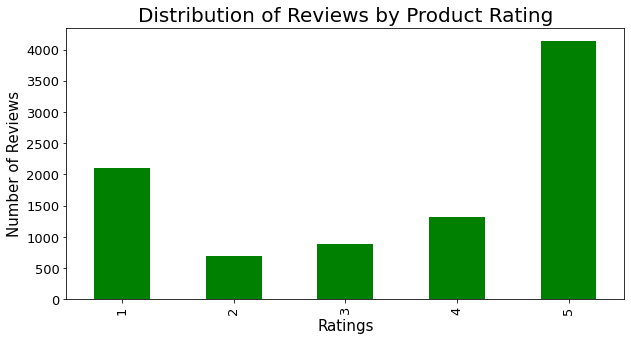

In [766]:
# plot the data
ax1 = ratings_review.plot(kind='bar', figsize=(10,5), color="green", fontsize = 13);
ax1.set_alpha(0.8)
ax1.set_title('Distribution of Reviews by Product Rating', fontsize = 20)
ax1.set_ylabel("Number of Reviews", fontsize = 15);
ax1.set_xlabel("Ratings", fontsize = 15 )
plt.show()


Mobile phones with higher rating receive the highest number of reviews followed by phones with the least review rating.

### 6.2. Brands with the highest reviews and with distribution of average prices

In [767]:
# Group relevant columns
brand_reviews = df.groupby('Brand')['Review'].count().sort_values(ascending = False).head(10)
brand_prices = df.groupby('Brand')['Price'].max().sort_values(ascending = False).head(10)

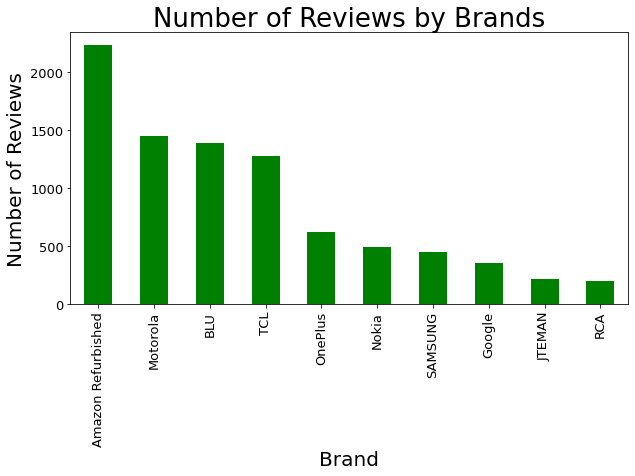

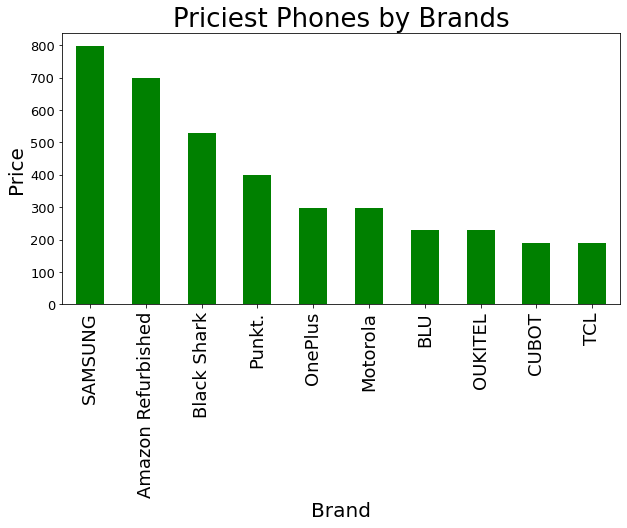

In [768]:
# Plot the data
ax1 = brand_reviews.plot(kind = 'bar', figsize = (10,5), color = 'green', fontsize = 13);
ax1.set_alpha(0.8)
ax1.set_title('Number of Reviews by Brands', fontsize = 26)
ax1.set_ylabel('Number of Reviews', fontsize = 20);
ax1.set_xlabel('Brand', fontsize = 20)
plt.show()


ax2 = brand_prices.plot(kind = 'bar', figsize = (10,5), color = 'green', fontsize = 13);
ax2.set_alpha(0.8)
ax2.set_title('Priciest Phones by Brands', fontsize = 26)
ax2.set_ylabel('Price', fontsize = 20);
ax2.set_xlabel('Brand', fontsize = 20)
plt.xticks(fontsize = 18)
plt.show()

Refurbished phones have the highest number of reviews while Samsung phones have the priciest phones. Samsung is one of the top phone brands in the world and with high performance, which could explain the high prices of its models.

### 6.3. Word cloud of the most-used words in reviews.

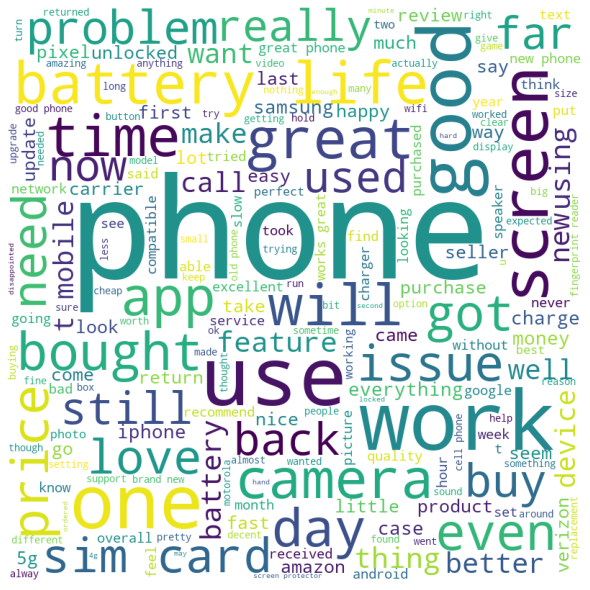

In [769]:
# Plot a word cloud 
comment_words = ''
stopwords = set(STOPWORDS)
 
# iterate through the csv file
for val in df.Review:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show() 

good, great, battery price, issue and work are some of the words that pop up more in the reviews

### 6.4. Trend of reviews over the years

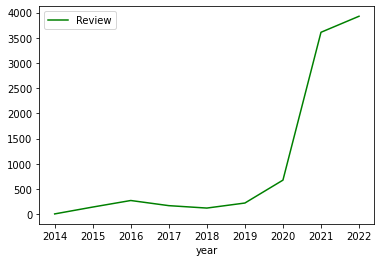

In [772]:
# Create a new dataframe to use while maintaining the original
new_df = df.copy()

# Extract year from the new dataframe
new_df['year'] = new_df['Review Date'].dt.year

# Group by relevant columns
review_date = new_df.groupby('year')['Review'].count()
review_date = pd.DataFrame(review_date).reset_index()

# plot the data
review_date.plot.line(x = 'year', y = 'Review', color = 'green');


The rate of customer reviews took a major increase from 2020. This could be attributed to the Covid Pandemic where people spent lots of time indoors and online shopping was at an all time high.

### 6.5. Relationship between price and Ratings

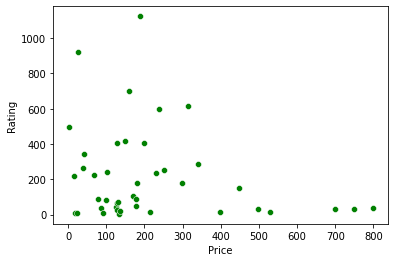

In [773]:
# Group by relevant columns
review_price = new_df.groupby('Price')['Rating'].count()
review_price = pd.DataFrame(review_price).reset_index()

# Plot the data
sns.scatterplot(x = 'Price', y = 'Rating', data = review_price, color = 'green')
plt.show()

# 5. Feature Engineering

# 7. Implementing the Solution

## 7.1 Preprocessing

# 8. Challenging the Solution

# 9. Conclusions

# 10. Recommendations